# Zadanie OneMoreGame

Załóżmy, że rozważamy inwestycję kapitałową w spółkę produkującą klasyczne gry PC. Gry podobne
do naszej analizowanej gry to:
* Prison Architect
* Stellaris
* XCOM 2
* Frostpunk
* Northgrad
* Ancestors Legacy
* Pahtom Doctrine
* Battle Star Galactica Deadlock

Tagi opisujące najlepiej naszą grę to:
* Simulation
* RTS
* Tactical
* Turn Based Strategy
* Building
* Turn Based Tactic
* Sci-Fi
* Co-op

Developer gry sugeruje rozpoczęcie rozmów z wydawcami:
* Slitherine Ltd.
* Team17 Digital. Ltd
* Paradox Interactive
* Maximum Games Kiss ltd
* Assemble Entertainment

Wykonaj następujące zadanie:
* Pobierz dane z serwisu SteamSpy
* Uzyskane dane przetwórz do jakiegoś sensownego formatu
* Na podstawie tych danych podaj największe sukcesy w segmencie rynku gier opisanych tymi
samymi tagami
* Na podstawie tych danych podaj, który z powyższych wydawców posiada doświadczenie potrzebne
do wydania naszej gry
* Na podstawie tych danych określ, z którym z nich warto prowadzić rozmowy

In [1]:
#import bibliotek
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns

%matplotlib inline

Dane z serwisu SteamSpy można pobrać na dwa sposoby. 
<br> Pierwszym z nich jest bezpośrednie odpytanie Steam Spy Api przy użyciu pythonowej biblioteki requests.
Drugi sposób znalazłem przypadkowo.
<br> Podczas zbierania wstępnych informacji o Steam Spy natknąłem się również na 'steamspypi' dostępną w dystrybucji pypi.org.
<br> W pierwszym etapie zdecydowałem się na odpytywanie Steam Spy Api przy użyciu sposobu numer 1. Na samym końcu pokażę możliwości 'steamspypi'.

Dokumentacja na temat steamspypi:
https://github.com/woctezuma/steamspypi

In [2]:
#instalacja steamspypi
!pip install --prefix {sys.prefix} steamspypi

In [41]:
import steamspypi

### Pobieranie danych z serwisu SteamSpy oraz zapisanie do csv.

Pętla 'for' zapełni listę 'tag_list' pandasowymi dataframe.
<br> Przy tworzeniu dataframów zdecydowałem się użyć następujących kolumn:'appid','developer','name','owners','positive', 'negative','publisher', 'score_rank','userscore','average_forever','median_forever'.

Dodatkowo utworzyłem kolumne 'tag_name', która później przyda się podczas tworzenia tabel przestawnych.

In [3]:
tags = ['Simulation',
        'RTS',
        'Tactical',
        'Turn Based Strategy',
        'Building',
        'Turn Based Tactic',
        'Sci-Fi',
        'Co-op']

tag_list = []

for tag in tags:
    tag_ = tag.replace(' ','%').lower()
    tag_response = requests.get('http://steamspy.com/api.php?request=tag&tag={}'.format(tag_))
    tag_response_ = tag_response.json()
    tag_response_df = pd.DataFrame(tag_response_).transpose().reset_index()
    clean_tag_response_df = tag_response_df.loc[:,['appid','developer','name','owners',
                                             'positive', 'negative','publisher',
                                             'score_rank','userscore','average_forever', 'median_forever']]
    clean_tag_response_df['tag_name'] = tag
    tag_list.append(clean_tag_response_df)

In [4]:
#łączenie dataframeów w całość
df_tags = pd.concat(tag_list, ignore_index=True)

In [5]:
df_tags.head(3)

,appid,developer,name,owners,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name
0,570,Valve,Dota 2,"100,000,000 .. 200,000,000",851989,137583,Valve,66,86,29522,595,Simulation
1,578080,PUBG Corporation,PLAYERUNKNOWN'S BATTLEGROUNDS,"50,000,000 .. 100,000,000",485605,473832,PUBG Corporation,11,49,20043,10105,Simulation
2,227940,RETO MOTO,Heroes & Generals,"10,000,000 .. 20,000,000",64875,33565,RETO MOTO,26,65,1002,87,Simulation


W kolejnym kroku zabrałem się za konwertowanie danych w kolumnach do typów kategorycznych oraz numerycznych.
<br> Ten zabieg pozwoli mi na sprawne operowanie funkcjami aggregacyjnymi przy tworzeniu tabel przestawnych.
<br> Dodaję również kolumnę 'avg owners', która jest wynikową (średnią) wartości minimalnej i maksymalnej z kolumny 'owners'.

Dodatkowo typy te zmniejszą rozmiar pliku CSV.

In [6]:
#konwertowanie typów
df_tags['developer'] = df_tags['developer'].astype('category') 
df_tags['publisher'] = df_tags['publisher'].astype('category')
df_tags['tag_name'] = df_tags['tag_name'].astype('category')
df_tags['positive'] = pd.to_numeric(df_tags['positive'])
df_tags['negative'] = pd.to_numeric(df_tags['negative'])
df_tags['score_rank'] = pd.to_numeric(df_tags['score_rank'])
df_tags['userscore'] = pd.to_numeric(df_tags['userscore'])
df_tags['average_forever'] = pd.to_numeric(df_tags['average_forever'])
df_tags['median_forever'] = pd.to_numeric(df_tags['median_forever'])

In [7]:
#tworzenie nowej columny z średnią wartością graczy
owners = df_tags['owners'].str.replace(',','').str.split(' .. ',expand=True)
owners.rename(columns={0:'minimum',1:'maximum'}, inplace=True)

owners['minimum'] = pd.to_numeric(owners['minimum'])
owners['maximum'] = pd.to_numeric(owners['maximum'])

owners['avg_owners'] = (owners['maximum'] + owners['minimum']) // 2

In [8]:
owners.head(3)

,minimum,maximum,avg_owners
0,100000000,200000000,150000000
1,50000000,100000000,75000000
2,10000000,20000000,15000000


In [9]:
#łączenie tabeli
df_tags_list = [df_tags, owners['avg_owners']]
df_tags_2 = pd.concat(df_tags_list, axis=1)
df_tags_2.drop(columns='owners', inplace=True)

In [10]:
df_tags_2.head()

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners
0,570,Valve,Dota 2,851989,137583,Valve,66.0,86,29522,595,Simulation,150000000
1,578080,PUBG Corporation,PLAYERUNKNOWN'S BATTLEGROUNDS,485605,473832,PUBG Corporation,11.0,49,20043,10105,Simulation,75000000
2,227940,RETO MOTO,Heroes & Generals,64875,33565,RETO MOTO,26.0,65,1002,87,Simulation,15000000
3,218620,OVERKILL - a Starbreeze Studio.,PAYDAY 2,306750,56563,Starbreeze Publishing AB,61.0,84,4427,849,Simulation,15000000
4,236390,Gaijin Entertainment,War Thunder,82238,20836,Gaijin Entertainment,49.0,79,3536,339,Simulation,15000000


Zaggregowane dane postanowiłem zapisać w pliku .CSV z separatowem w postaci ','. 

In [11]:
df_tags_2.to_csv('steamspy_tags.csv', sep=',')

Text(0.5, 1.0, 'ILOŚĆ GIER Z DANYM TAGIEM')

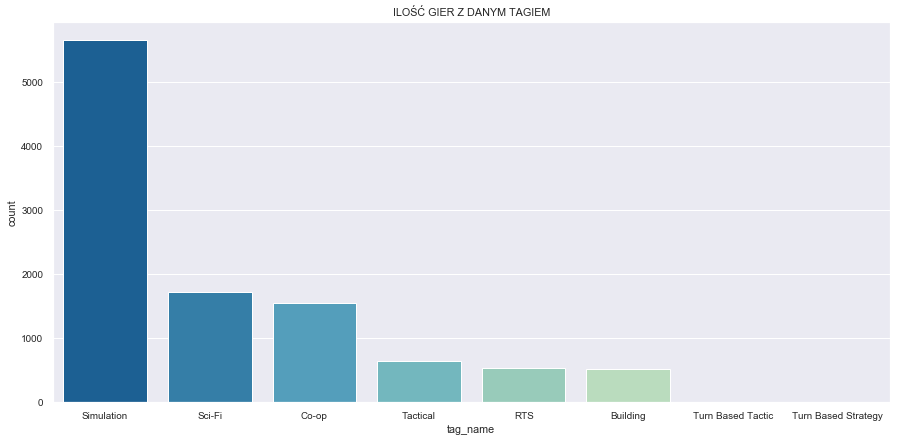

In [55]:
#wstępna wizualizacja wyników
plt.figure(figsize=(15,7))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 2.5})

sns.countplot(x='tag_name',
              data=df_tags_2,
              palette="GnBu_r",
              order = df_tags_2['tag_name'].value_counts().index)

plt.title("ILOŚĆ GIER Z DANYM TAGIEM")

Wstępna wizualizacja pokazuje, że dominującym tagiem w tym datasecie jest 'Simulation'.
<br> Z kolei tagi 'Turn Based Strategy' oraz 'Turn Based Tactic' mają znikomy udział w rynku oznaczonym ww tagami.

### Największe sukcesy w segmencie rynku gier opisanych ww  tagami.

Sukcesy w segmentach opisanych tagami postanowiłem rozbić na kilka grup.
<br> Biorę pod uwagę pozytywne głosy, ilość graczy oraz średni czas gry począwszy od marca 2009 (w minutach).
<br> Na samym początku tworzę tabelę przestawną, która zwraca mi maksymalne wartości zadanej wielkości, <br> następnię sortuję tę tabelę per tag w kolejności od największego wyniku do najmniejszego.
<br> Następnie przy użyciu funkcji get_top1_from_tags zwracam top wartość dla każdej grupy tagów.

In [13]:
positive = pd.pivot_table(df_tags_2,
                          index=['tag_name','name'],
                          values='positive',
                          aggfunc=max).reset_index().sort_values(by=['tag_name','positive'], ascending=False)

In [14]:
positive.head(5)

,tag_name,name,positive
10641,Turn Based Tactic,Grand Theft Auto IV,34648
10645,Turn Based Tactic,Rock of Ages,2601
10643,Turn Based Tactic,PewDiePie: Legend of the Brofist,1086
10648,Turn Based Tactic,Zombie Bowl-o-Rama,241
10647,Turn Based Tactic,VR SUPER SPORTS,41


In [15]:
def get_top1_from_tags(group, group_by):
    '''
    Funkcja zwraca top wartość z danej grupy.
    '''
    return group.sort_values(by=group_by, ascending=False)[:1]

grouped = positive.groupby('tag_name')
top_tags = grouped.apply(get_top1_from_tags, 'positive').set_index('tag_name')

top_tags.sort_values(by='tag_name', ascending=False)

,name,positive
tag_name,,
Turn Based Tactic,Grand Theft Auto IV,34648
Turn Based Strategy,Grand Theft Auto IV,34648
Tactical,Counter-Strike: Global Offensive,2563015
Simulation,Dota 2,851989
Sci-Fi,Warframe,220654
RTS,Dota 2,851989
Co-op,Counter-Strike: Global Offensive,2563015
Building,Garry's Mod,357658


Na podstawie powyższej tabeli możemy stwierdzić, że największe sukcesy w segmencie rynku gier opisanych podanymi tagami pod względem ilości pozytywnych opinii odnoszą Grand Theft Auto IV, Counter-Strike: GO, Dota 2, Warframe, Garry's Mod.

In [16]:
owners = pd.pivot_table(df_tags_2,
                        index=['tag_name','name'],
                        values='avg_owners',
                        aggfunc=max).reset_index().sort_values(by=['tag_name','avg_owners'], ascending=False)

grouped_2 = owners.groupby('tag_name')
top_owners = grouped_2.apply(get_top1_from_tags, 'avg_owners').set_index('tag_name')

top_owners.sort_values(by='tag_name', ascending=False)

,name,avg_owners
tag_name,,
Turn Based Tactic,Grand Theft Auto IV,3500000
Turn Based Strategy,Grand Theft Auto IV,3500000
Tactical,PLAYERUNKNOWN'S BATTLEGROUNDS,75000000
Simulation,Dota 2,150000000
Sci-Fi,Warframe,35000000
RTS,Dota 2,150000000
Co-op,Dota 2,150000000
Building,Garry's Mod,15000000


Na podstawie powyższej tabeli możemy stwierdzić, że największe sukcesy w segmencie rynku gier opisanych podanymi tagami pod względem średniej ilości użytkowników odnoszą: Grand Theft Auto IV, PLAYERUNKNOWN'S BATTLEGROUNDS, Dota 2, Warframe oraz Garry's Mod.

In [17]:
average_forever = pd.pivot_table(df_tags_2,
                                 index=['tag_name','name'],
                                 values='average_forever',
                                 aggfunc=max).reset_index().sort_values(by=['tag_name','average_forever'], ascending=False)

grouped_3 = average_forever.groupby('tag_name')
top_avg_forever = grouped_3.apply(get_top1_from_tags, 'average_forever').set_index('tag_name')

top_avg_forever.sort_values(by='tag_name', ascending=False)

,name,average_forever
tag_name,,
Turn Based Tactic,Grand Theft Auto IV,1789
Turn Based Strategy,Grand Theft Auto IV,1789
Tactical,Counter-Strike: Global Offensive,32354
Simulation,>//:System.Hack,134253
Sci-Fi,>//:System.Hack,134253
RTS,Dota 2,29522
Co-op,Counter-Strike: Global Offensive,32354
Building,Trainz: A New Era,16841


Na podstawie powyższej tabeli możemy stwierdzić, że największe sukcesy w segmencie rynku gier opisanych podanymi tagami pod względem średniego czasu gry począwszy od marca 2009 odnoszą Grand Theft Auto IV, Counter-Strike: GO, Trainz: A New Era, >//:System.Hack.

### Który z podanych wydawców posiada doświadczenie potrzebne do wydania gry?

Określając doświadczenie wydawcy na wstępnym poziomie, zakładam, że zsumowana ilość gier otagowana podanymi tagami będzie wyznacznikiem doświadczenia. Idealny wydawca, to taki, który miał już wcześniej styczność z daną branżą.

<br> Najpierw tworzę tabelę przestawną posegmentowaną nazwą wydawcy oraz tagiem, za doświadczenie posłuży mi funkcja len, która w tym wypadku zwraca zsumowaną ilość gier w danym segmencie.
Nastepnie grupuję ten dataframe na wydawców i sumuję wystąpienia gier.
<br> Kolejnym krokiem jest sprawdzenie, którzy z podanych wydawców pojawili się w wynikowym dataframe.

In [18]:
publishers =['Slitherine Ltd.',
             'Team17 Digital. Ltd',
             'Paradox Interactive',
             'Maximum Games Kiss ltd',
             'Assemble Entertainment']

In [19]:
exp = pd.pivot_table(df_tags,
                     index=['publisher','tag_name'],
                     values='appid', 
                     aggfunc=len).reset_index().sort_values(by=['appid','publisher'], ascending=False)

In [20]:
exp_sum = exp.groupby('publisher').sum().reset_index().sort_values(by='appid', ascending = False)

In [21]:
#tworzenie zmiennych odpowiadających wydawcom
slitherine = exp_sum['publisher'] == publishers[0]
team17 = exp_sum['publisher'] == publishers[1]
paradox = exp_sum['publisher'] == publishers[2]
maximum_games = exp_sum['publisher'] == publishers[3]
assemble = exp_sum['publisher'] == publishers[4]

exp_sum.rename(columns={'appid' : 'experience'}, inplace=True)

In [22]:
#zwracanie wydawców z doświadczeniem w wybranych segmentach
exp_sum[slitherine | team17 | paradox | maximum_games | assemble].reset_index()

,index,publisher,experience
0,3728,Slitherine Ltd.,89.0
1,3074,Paradox Interactive,79.0
2,348,Assemble Entertainment,7.0


Zwrócony dataframe informuje nas, że wydawcy Slitherine Ltd., Paradox Interactive oraz Assemble Entertainment posiadają na swoim koncie gry o podobnej charakterystyce. Wybór wydawcy po samej ilości wydanych gier nie jest w stu procentach miarodajny. W kolejnych krokach pokażę dlaczego.

### Z którym z wydawców warto prowadzić rozmowy?

Tak jak wcześniej wspomniałem w tej sekcji użyję bardziej miarodajnego sposobu na wyliczenie porównanie doświadczenia wydawców. 
<br> Za wskaznik punktów doświadczenia posłuży mi średnia ważona o następujących wagach:
 
* doświadczenie w ilości wydanych gier (experience) : 4
2. liczba graczy (avg_owners) : 3
3. pozytywne opinie (positive): 2
4. negatywne opinie (negative): 2
5. średni czas gry począwszy od marca 2009 (average_forever): 1
6. przeciętny czas gry począwszy od marca 2009 (median_forever): 1

Tak jak wcześniej buduję tabelę przestawną, która zwróci mi wartości przydatne do obliczenia średniej ważonej.

In [23]:
exp_df = pd.pivot_table(df_tags_2,
                        index=['publisher'],
                        values=['appid', 'positive','negative','avg_owners','average_forever', 'median_forever'], 
                     aggfunc={'appid': len,
                              'positive': sum, 
                              'negative': sum ,
                              'avg_owners':sum,
                              'average_forever': np.mean,
                              'median_forever' : np.mean}).reset_index().sort_values(by=['appid'], ascending=False)

In [24]:
exp_df.head()

,publisher,appid,average_forever,avg_owners,median_forever,negative,positive
4276,Ubisoft,112,1239.160714,100880000,526.973214,425131,1375612
3728,Slitherine Ltd.,89,1161.932584,2965000,1312.426966,6827,21241
3074,Paradox Interactive,79,2062.582278,73710000,525.455696,152303,859552
3981,THQ Nordic,75,503.906667,25810000,238.506667,30368,102410
3534,SEGA,75,1479.306667,105830000,485.760000,116323,436084


In [25]:
exp_df[exp_df['publisher'] == 'Slitherine Ltd.']

,publisher,appid,average_forever,avg_owners,median_forever,negative,positive
3728,Slitherine Ltd.,89,1161.932584,2965000,1312.426966,6827,21241


In [26]:
#wzór z podstawionymi wartościami z wiersza wyżej
int((89*4 + 2965000*3 + 21241*2 + 6827*2 + 1161.932584*1 + 1312.426966*1)/13)

688766

Po obliczeniu wskaznik punktów doświadczenia wydawcy Slitherine Ltd. wynosi 688766 punktów.

In [27]:
exp_df[exp_df['publisher'] == 'Paradox Interactive']

,publisher,appid,average_forever,avg_owners,median_forever,negative,positive
3074,Paradox Interactive,79,2062.582278,73710000,525.455696,152303,859552


In [28]:
#wzór z podstawionymi wartościami z wiersza wyżej
int((79*4 + 73710000*3 + 859552*2 + 152303*2 + 2062.582278*1 + 525.455696*1)/13)

17165893

Po obliczeniu wskaznik punktów doświadczenia wydawcy Paradox Interactive wynosi 17165893 punktów.

In [29]:
exp_df[exp_df['publisher'] == 'Assemble Entertainment']

,publisher,appid,average_forever,avg_owners,median_forever,negative,positive
348,Assemble Entertainment,7,88.285714,95000,93.285714,504,441


In [30]:
#wzór z podstawionymi wartościami z wiersza wyżej
int((7*4 + 95000*3 + 441*2 + 504*2 + 88.285714*1 + 93.285714*1)/13)

22084

Po obliczeniu wskaznik punktów doświadczenia wydawcy Assemble Entertainment wynosi 17165893 punktów.

Podsumowując, najlepszym wyborem wsród wydawców według wskaznika punktów doświadczenia (średniej ważonej) będzie Paradox Interactive, którego gry odnoszą sukcesy w segmencie tagów podanych wyżej. Na przykładzie Slitherine Ltd.	 możemy zauważyć, że niekoniecznie ilość wydanych gier świadczy o sukcesie wydawcy.

W kolejnym kroku chcę sprawdzić wydawców gier podanych w tresci zadania jako gry podobne do analizowanej gry. <br> To pozwoli sprawdzić w pewnym sensie, czy wybór Paradox Interactive był słuszny.

In [31]:
games = ['Prison Architect',
         'Stellaris',
         'XCOM 2',
         'Frostpunk',
         'Northgrad',
         'Ancestors Legacy',
         'Pahtom Doctrine',
         'Battle Star Galactica Deadlock']

In [32]:
df_tags_2[df_tags_2['name'] == games[0]].head(1)

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners
63,233450,Introversion Software,Prison Architect,31206,2190,Paradox Interactive,87.0,93,1599,585,Simulation,3500000


In [33]:
df_tags_2[df_tags_2['name'] == games[1]].head(1)

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners
84,281990,Paradox Development Studio,Stellaris,34417,9647,Paradox Interactive,47.0,77,5051,1590,Simulation,1500000


In [34]:
df_tags_2[df_tags_2['name'] == games[2]].head(1)

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners
6242,268500,"Firaxis Games, Feral Interactive (Mac), Feral ...",XCOM 2,27944,6681,"2K, Feral Interactive (Mac), Feral Interactive...",52.0,81,3231,1742,Tactical,1500000


In [35]:
df_tags_2[df_tags_2['name'] == games[3]].head(1)

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners
126,323190,11 bit studios,Frostpunk,21246,2836,11 bit studios,72.0,87,766,478,Simulation,1500000


In [36]:
df_tags_2[df_tags_2['name'] == games[4]].head(1)

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners


In [37]:
df_tags_2[df_tags_2['name'] == games[5]].head(1)

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners
5880,620590,Destructive Creations,Ancestors Legacy,1829,640,1C Entertainment,40.0,78,611,387,RTS,75000


In [38]:
df_tags_2[df_tags_2['name'] == games[6]].head(1)

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners


In [39]:
df_tags_2[df_tags_2['name'] == games[7]].head(1)

,appid,developer,name,positive,negative,publisher,score_rank,userscore,average_forever,median_forever,tag_name,avg_owners


<br> Kolejnym ciekawym sprawdzeniem naszego typu wydaje się 'przekopanie' tabeli 'top100forever' w poszukiwaniu gier wydanych przez Paradox Interactive.
<br> Do tego celu użyję biblioteki steamspypi.

In [45]:
data_request = dict()
data_request['request'] = 'top100forever'

data = steamspypi.download(data_request)

In [49]:
data_top100 = pd.DataFrame(data).transpose()

In [50]:
data_top100[data_top100['publisher'] == 'Paradox Interactive']

,appid,average_2weeks,average_forever,developer,discount,initialprice,median_2weeks,median_forever,name,negative,owners,positive,price,publisher,score_rank,userscore
255710,255710,314,2079,Colossal Order Ltd.,75,2999,98,655,Cities: Skylines,5685,"2,000,000 .. 5,000,000",65362,749,Paradox Interactive,79,91


In [51]:
data_top100[data_top100['publisher'] == 'Slitherine Ltd.']

,appid,average_2weeks,average_forever,developer,discount,initialprice,median_2weeks,median_forever,name,negative,owners,positive,price,publisher,score_rank,userscore


In [52]:
data_top100[data_top100['publisher'] == 'Assemble Entertainment']

,appid,average_2weeks,average_forever,developer,discount,initialprice,median_2weeks,median_forever,name,negative,owners,positive,price,publisher,score_rank,userscore


<b> Podsumowując,  wydawca Paradox Interactive jest bardzo dobrym wyborem ponieważ:

   * posiada bardzo duże doświadczenie w segmencie gier opisanych podanymi tagami,
   * dwie z podanych jako podobne gier zostało wydane przez Paradox Interactive,
   * w przeciwieństwie do innych doświadczonych wydawców Paradox Interactive posiada duży sukces na swoim koncie czyli grę Cities: Skylines, która     uplasowała się w TOP 100 gier według serwisu SteamSpy.